In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import pandas as pd
# import sagemaker
# from sagemaker.pytorch import PyTorch
# from sagemaker.tuner import (
#     IntegerParameter,
#     HyperparameterTuner,
# )

from src import fetch_bucketed_from_bitmex, preprocess, evaluate, train_linear, train_lstm

input_dir = 'cache_input'
model_dir = 'cache_model'
output_dir = 'cache_output'
# role = sagemaker.get_execution_role()
# sagemaker_session = sagemaker.Session()
# bucket = sagemaker_session.default_bucket()

# Crawling the Dataset

In [2]:
df = fetch_bucketed_from_bitmex('XBTZ19', '1m')

# Feature Engineering

In [3]:
preprocess(df, input_dir)

# Training

### Benchmark: Linear Model

In [2]:
train_linear(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    hidden_dim= 64,
    n_epochs= 16,
    batch_size= 1024,
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 6.450e-01 | 9.033e-01 |      0 |
|     1 | 5.936e-01 | 9.734e-01 |      0 |
|     2 | 5.624e-01 | 1.025e+00 |      0 |
|     3 | 5.383e-01 | 1.061e+00 |      0 |
|     4 | 5.176e-01 | 1.064e+00 |      0 |
|     5 | 5.158e-01 | 1.065e+00 |      0 |
|     6 | 5.141e-01 | 1.066e+00 |      0 |
|     7 | 5.124e-01 | 1.066e+00 |      0 |
|     8 | 5.109e-01 | 1.066e+00 |      0 |
|     9 | 5.107e-01 | 1.066e+00 |      0 |
|    10 | 5.106e-01 | 1.066e+00 |      0 |
|    11 | 5.104e-01 | 1.066e+00 |      0 |
|    12 | 5.103e-01 | 1.066e+00 |      0 |
|    13 | 5.103e-01 | 1.066e+00 |      0 |
|    14 | 5.102e-01 | 1.066e+00 |      0 |
|    15 | 5.102e-01 | 1.066e+00 |      0 |
loss of trai is 0.510
loss of vali is 1.066
loss of test is 3.235


### Solution: LSTM Model

In [7]:
# inputs = sagemaker_session.upload_data(
#     path=input_dir, bucket=bucket, key_prefix="lstm-trader"
# )

# estimator = PyTorch(
#     source_dir="src",
#     entry_point="trainer.py",
#     hyperparameters={
#         "seq-len": 19,
#         "hidden-dim": 256,
#         "n-epochs": 16,
#         "batch-size": 1024,
#     },
#     framework_version="1.2.0",
#     role=role,
#     sagemaker_session=sagemaker_session,
#     train_instance_count=1,
#     train_instance_type="ml.p2.xlarge",
# )

# estimator.fit({"data_dir": inputs})

train_lstm(
    input_dir=input_dir,
    output_dir=output_dir,
    model_dir=model_dir,
    hidden_dim= 64,
    dropout=0,
    n_epochs= 16,
    batch_size= 1024,
)

Using device cpu.
| epoch | trai loss | vali loss | time/s |
| ----: | --------- | --------- | -----: |
|     0 | 8.281e-01 | 3.696e-01 |      0 |
|     1 | 6.923e-01 | 3.551e-01 |      0 |
|     2 | 5.755e-01 | 3.391e-01 |      0 |
|     3 | 4.646e-01 | 3.215e-01 |      0 |
|     4 | 3.737e-01 | 3.196e-01 |      0 |
|     5 | 3.630e-01 | 3.176e-01 |      0 |
|     6 | 3.523e-01 | 3.155e-01 |      0 |
|     7 | 3.416e-01 | 3.133e-01 |      0 |
loss of trai is 0.333
loss of vali is 0.313
loss of test is 1.410


In [3]:
# tuner = HyperparameterTuner(
#     estimator,
#     objective_metric_name="validation loss",
#     hyperparameter_ranges={
#         "seq-len": IntegerParameter(8, 256),
#         "hidden-dim": IntegerParameter(8, 128),
#     },
#     metric_definitions=[
#         {"Name": "validation loss", "Regex": "loss of vali is ([-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+))"}
#     ],
#     max_jobs=16,
#     max_parallel_jobs=1,
#     objective_type="Minimize",
# )

# tuner.fit({"data_dir": inputs})

In [4]:
# sagemaker_session.download_data(
#     path=model_dir,
#     bucket=bucket,
#     key_prefix=estimator.latest_training_job.name + "/output/model.tar.gz",
# )
# !tar xvf cache_model/model.tar.gz --directory=cache_model

lstm.pth


# Evaluation

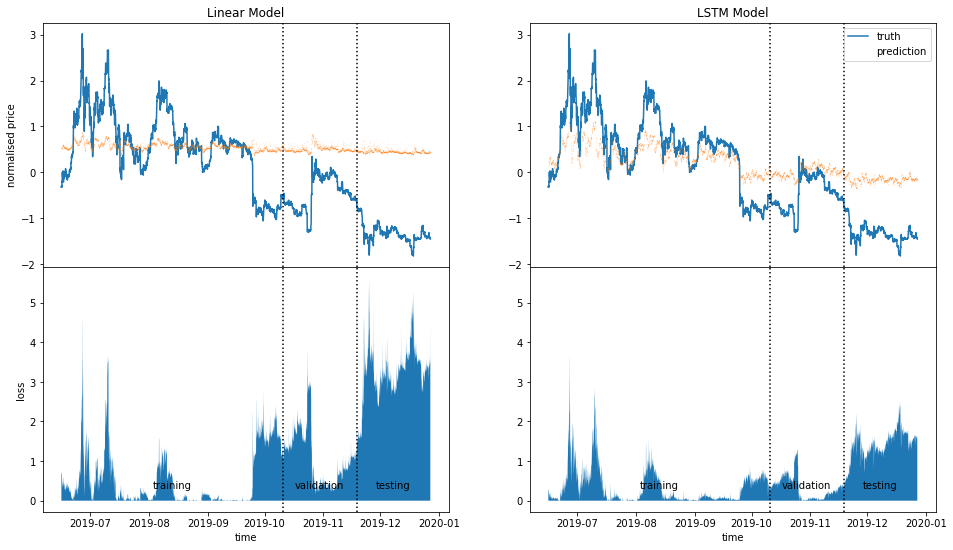

In [9]:
evaluate(input_dir, output_dir)